In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt
from utils import display_img, process
from latent_dataset import WPlusLatentsDataset
from SAE import SparseAutoencoder
from torch.utils.data import DataLoader
from evaluate_saes import test_reconstructions
import einops

In [2]:
device = 'mps'

In [3]:
TRAIN_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_train_latents'
train_data = WPlusLatentsDataset(TRAIN_PATH)
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

VAL_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_val_latents'
val_data = WPlusLatentsDataset(VAL_PATH)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [4]:
SAE = SparseAutoencoder(latent_dim = 512, hidden_dim = 1024, sparsity_lambda = 0.2, device = device).to(device)

In [5]:
def train_sae_epoch(sae, loader, optimizer):
    total_losses = []
    reconstruction_losses = []
    sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        optimizer.zero_grad()
        batch = batch.to(sae.device)
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        total_loss.backward()
        optimizer.step()
        total_losses.append(total_loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        sparsity_losses.append(sparsity_loss.item())
    return total_losses, reconstruction_losses, sparsity_losses

def train_sae(sae, train_loader, val_loader, optimizer, num_epochs, resampling_epochs):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    eval_losses = []
    eval_recon_losses = []
    eval_sparsity_losses = []
    for i in range(num_epochs):
        print(f'Starting epoch {i}!')
        total_losses, reconstruction_losses, sparsity_losses = train_sae_epoch(sae, train_loader, optimizer)
        all_total_losses.extend(total_losses)
        all_reconstruction_losses.extend(reconstruction_losses)
        all_sparsity_losses.extend(sparsity_losses)
        avg_total_loss, avg_recon_loss, avg_sparsity_loss = evaluate(SAE, val_loader)
        eval_losses.append(avg_total_loss)
        eval_recon_losses.append(avg_recon_loss)
        eval_sparsity_losses.append(avg_sparsity_loss)
        print(f'Evaluation loss: {avg_total_loss}, Reconstruction loss: {avg_recon_loss}, Sparsity Loss: {avg_sparsity_loss}')
        if i in resampling_epochs:
            batch = next(iter(train_loader))
            with torch.no_grad():
                reconstructions, latents = sae(batch)
            sae.resample_dead_features(batch, latents, activation_threshold = 1e-4)
        print('\n')
    return all_total_losses, all_reconstruction_losses, all_sparsity_losses, eval_losses, eval_recon_losses, eval_sparsity_losses

@torch.inference_mode()
def evaluate(sae, loader):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        all_total_losses.append(total_loss.item())
        all_reconstruction_losses.append(reconstruction_loss.item())
        all_sparsity_losses.append(sparsity_loss.item())
    avg_total_loss = sum(all_total_losses) / len(all_total_losses)
    avg_recon_loss = sum(all_reconstruction_losses) / len(all_reconstruction_losses)
    avg_sparsity_loss = sum(all_sparsity_losses) / len(all_sparsity_losses)
    return avg_total_loss, avg_recon_loss, avg_sparsity_loss

In [6]:
optimizer = torch.optim.SGD(params = SAE.parameters(), lr = 1e-3)

In [7]:
all_total_losses, all_reconstruction_losses, all_sparsity_losses, eval_losses, eval_recon_losses, eval_sparsity_losses = train_sae(SAE, train_loader, val_loader, optimizer, 35, {5, 7, 9, 11, 13, 15, 17})

Starting epoch 0!


100%|██████████| 32/32 [00:03<00:00,  8.57it/s]


Evaluation loss: 0.20866625476628542, Reconstruction loss: 0.18221871741116047, Sparsity Loss: 0.1322376891039312


Starting epoch 1!


100%|██████████| 32/32 [00:03<00:00,  8.58it/s]


Evaluation loss: 0.2060771808028221, Reconstruction loss: 0.17931907484307885, Sparsity Loss: 0.13379053073003888


Starting epoch 2!


100%|██████████| 32/32 [00:03<00:00,  8.50it/s]


Evaluation loss: 0.20357236452400684, Reconstruction loss: 0.17650181939825416, Sparsity Loss: 0.13535271910950541


Starting epoch 3!


100%|██████████| 32/32 [00:04<00:00,  7.31it/s]


Evaluation loss: 0.2010651151649654, Reconstruction loss: 0.17368251085281372, Sparsity Loss: 0.13691302249208093


Starting epoch 4!


100%|██████████| 32/32 [00:03<00:00,  8.43it/s]


Evaluation loss: 0.19874405348673463, Reconstruction loss: 0.1710442714393139, Sparsity Loss: 0.13849890884011984


Starting epoch 5!


100%|██████████| 32/32 [00:03<00:00,  8.58it/s]


Evaluation loss: 0.1963212681002915, Reconstruction loss: 0.16831545159220695, Sparsity Loss: 0.1400290746241808
None Resampled!


Starting epoch 6!


100%|██████████| 32/32 [00:03<00:00,  8.45it/s]


Evaluation loss: 0.19394455524161458, Reconstruction loss: 0.1656383932568133, Sparsity Loss: 0.14153081644326448


Starting epoch 7!


100%|██████████| 32/32 [00:04<00:00,  7.78it/s]


Evaluation loss: 0.191796715836972, Reconstruction loss: 0.1631789836101234, Sparsity Loss: 0.14308865880593657
None Resampled!


Starting epoch 8!


100%|██████████| 32/32 [00:04<00:00,  7.76it/s]


Evaluation loss: 0.18950330279767513, Reconstruction loss: 0.16059240885078907, Sparsity Loss: 0.14455446740612388


Starting epoch 9!


100%|██████████| 32/32 [00:04<00:00,  7.78it/s]


Evaluation loss: 0.18734301254153252, Reconstruction loss: 0.15813654568046331, Sparsity Loss: 0.14603233197703958
None Resampled!


Starting epoch 10!


100%|██████████| 32/32 [00:04<00:00,  7.91it/s]


Evaluation loss: 0.18524961592629552, Reconstruction loss: 0.1557542011141777, Sparsity Loss: 0.14747706847265363


Starting epoch 11!


100%|██████████| 32/32 [00:03<00:00,  8.11it/s]


Evaluation loss: 0.1832367437891662, Reconstruction loss: 0.15345654683187604, Sparsity Loss: 0.14890098245814443
None Resampled!


Starting epoch 12!


100%|██████████| 32/32 [00:03<00:00,  8.16it/s]


Evaluation loss: 0.18120591901242733, Reconstruction loss: 0.15114834159612656, Sparsity Loss: 0.15028788382187486


Starting epoch 13!


100%|██████████| 32/32 [00:04<00:00,  7.47it/s]


Evaluation loss: 0.17910674540326, Reconstruction loss: 0.14879525965079665, Sparsity Loss: 0.15155743481591344
None Resampled!


Starting epoch 14!


100%|██████████| 32/32 [00:04<00:00,  7.88it/s]


Evaluation loss: 0.1773197976872325, Reconstruction loss: 0.14673951920121908, Sparsity Loss: 0.15290139662101865


Starting epoch 15!


100%|██████████| 32/32 [00:04<00:00,  7.75it/s]


Evaluation loss: 0.17546631768345833, Reconstruction loss: 0.14462948311120272, Sparsity Loss: 0.15418417053297162
None Resampled!


Starting epoch 16!


100%|██████████| 32/32 [00:04<00:00,  7.51it/s]


Evaluation loss: 0.17376045184209943, Reconstruction loss: 0.14266898529604077, Sparsity Loss: 0.155457335524261


Starting epoch 17!


100%|██████████| 32/32 [00:04<00:00,  7.83it/s]


Evaluation loss: 0.17208872642368078, Reconstruction loss: 0.14075548527762294, Sparsity Loss: 0.15666620060801506
None Resampled!


Starting epoch 18!


100%|██████████| 32/32 [00:03<00:00,  8.10it/s]


Evaluation loss: 0.17051211977377534, Reconstruction loss: 0.1389399878680706, Sparsity Loss: 0.15786064695566893


Starting epoch 19!


100%|██████████| 32/32 [00:04<00:00,  7.86it/s]


Evaluation loss: 0.1689054979942739, Reconstruction loss: 0.13711281912401319, Sparsity Loss: 0.1589633864350617


Starting epoch 20!


100%|██████████| 32/32 [00:03<00:00,  8.07it/s]


Evaluation loss: 0.167512028478086, Reconstruction loss: 0.13548161555081606, Sparsity Loss: 0.1601520604453981


Starting epoch 21!


100%|██████████| 32/32 [00:04<00:00,  7.95it/s]


Evaluation loss: 0.1660134899429977, Reconstruction loss: 0.13377679605036974, Sparsity Loss: 0.1611834652721882


Starting epoch 22!


100%|██████████| 32/32 [00:04<00:00,  7.95it/s]


Evaluation loss: 0.16462154872715473, Reconstruction loss: 0.1321836900897324, Sparsity Loss: 0.16218928107991815


Starting epoch 23!


100%|██████████| 32/32 [00:04<00:00,  7.81it/s]


Evaluation loss: 0.16326637659221888, Reconstruction loss: 0.13063016068190336, Sparsity Loss: 0.16318108001723886


Starting epoch 24!


100%|██████████| 32/32 [00:04<00:00,  7.83it/s]


Evaluation loss: 0.16205092193558812, Reconstruction loss: 0.12922148033976555, Sparsity Loss: 0.1641471991315484


Starting epoch 25!


100%|██████████| 32/32 [00:04<00:00,  7.78it/s]


Evaluation loss: 0.16084648808464408, Reconstruction loss: 0.1278283023275435, Sparsity Loss: 0.16509091947227716


Starting epoch 26!


100%|██████████| 32/32 [00:04<00:00,  7.65it/s]


Evaluation loss: 0.15968397818505764, Reconstruction loss: 0.12648613844066858, Sparsity Loss: 0.1659891875460744


Starting epoch 27!


100%|██████████| 32/32 [00:03<00:00,  8.38it/s]


Evaluation loss: 0.15867456886917353, Reconstruction loss: 0.12529320735484362, Sparsity Loss: 0.16690680850297213


Starting epoch 28!


100%|██████████| 32/32 [00:03<00:00,  8.02it/s]


Evaluation loss: 0.1575184827670455, Reconstruction loss: 0.12398211192339659, Sparsity Loss: 0.1676818449050188


Starting epoch 29!


100%|██████████| 32/32 [00:04<00:00,  8.00it/s]


Evaluation loss: 0.1565056494437158, Reconstruction loss: 0.12280986923724413, Sparsity Loss: 0.16847890010103583


Starting epoch 30!


100%|██████████| 32/32 [00:03<00:00,  8.06it/s]


Evaluation loss: 0.15550282690674067, Reconstruction loss: 0.12165840086527169, Sparsity Loss: 0.16922212485224009


Starting epoch 31!


100%|██████████| 32/32 [00:04<00:00,  7.99it/s]


Evaluation loss: 0.15473785856738687, Reconstruction loss: 0.12071531661786139, Sparsity Loss: 0.1701127039268613


Starting epoch 32!


100%|██████████| 32/32 [00:03<00:00,  8.60it/s]


Evaluation loss: 0.15372650511562824, Reconstruction loss: 0.11958242207765579, Sparsity Loss: 0.17072041565552354


Starting epoch 33!


100%|██████████| 32/32 [00:04<00:00,  7.90it/s]


Evaluation loss: 0.15283455653116107, Reconstruction loss: 0.11854997556656599, Sparsity Loss: 0.17142289457842708


Starting epoch 34!


100%|██████████| 32/32 [00:04<00:00,  7.91it/s]

Evaluation loss: 0.15204314701259136, Reconstruction loss: 0.11761705717071891, Sparsity Loss: 0.17213043989613652




In [19]:
total_losses, reconstruction_losses, sparsity_losses = torch.tensor(all_total_losses), torch.tensor(all_reconstruction_losses), torch.tensor(all_sparsity_losses)

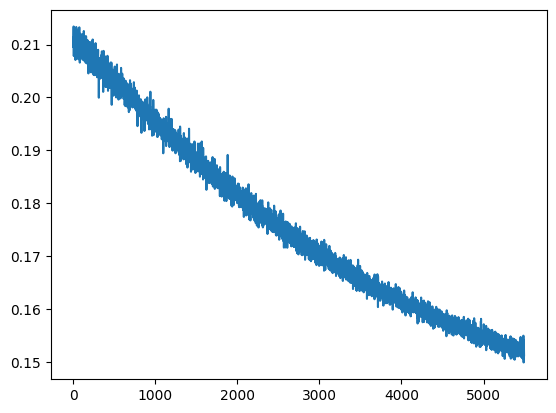

In [9]:
plt.plot(torch.clamp(total_losses, 0, 0.5))
plt.show()

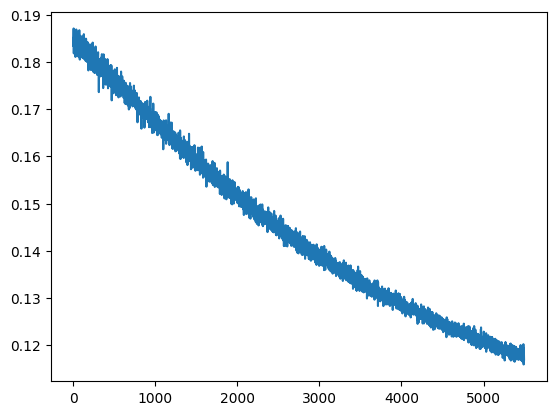

In [10]:
plt.plot(torch.clamp(reconstruction_losses, 0, 0.5))
plt.show()

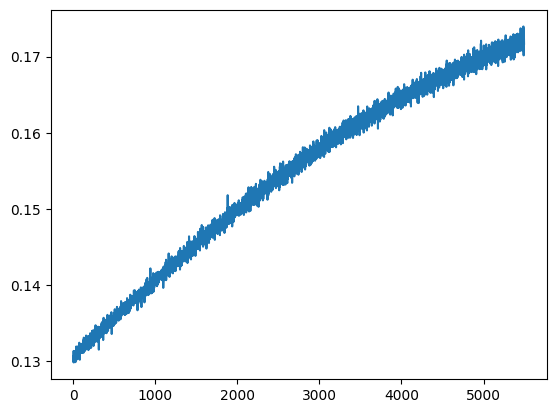

In [11]:
plt.plot(torch.clamp(sparsity_losses, 0, 0.5))
plt.show()

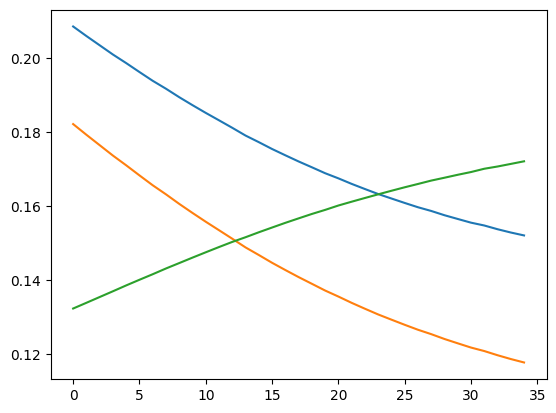

In [12]:
plt.plot(eval_losses, label = 'Total loss')
plt.plot(eval_recon_losses, label = 'Reconstruction Loss')
plt.plot(eval_sparsity_losses, label = 'Sparsity Losses')
plt.show()

# Evaluation

In [13]:
VAL_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_val_latents'
val_data = WPlusLatentsDataset(VAL_PATH)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [14]:
@torch.inference_mode()
def evaluate(sae, loader):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        all_total_losses.append(total_loss.item())
        all_reconstruction_losses.append(reconstruction_loss.item())
        all_sparsity_losses.append(sparsity_loss.item())
    avg_total_loss = sum(all_total_losses) / len(all_total_losses)
    avg_recon_loss = sum(all_reconstruction_losses) / len(all_reconstruction_losses)
    avg_sparsity_loss = sum(all_sparsity_losses) / len(all_sparsity_losses)
    return avg_total_loss, avg_recon_loss, avg_sparsity_loss

In [15]:
avg_total_loss, avg_recon_loss, avg_sparsity_loss = evaluate(SAE, val_loader)

100%|██████████| 32/32 [00:03<00:00, 10.04it/s]


# Visualize Some Reconstructions

In [16]:
import dnnlib
import legacy
from latent_dataset import save_latents

In [17]:
# downloaded from https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan2/files

FILEPATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/load_pretrained_stylegan/stylegan2-celebahq-256x256.pkl'
with dnnlib.util.open_url(FILEPATH) as f:
    data = legacy.load_network_pkl(f)
    G = data["G_ema"].eval().to("mps")

Original Images:


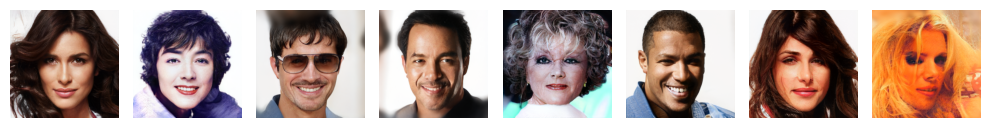

Reconstructed Images


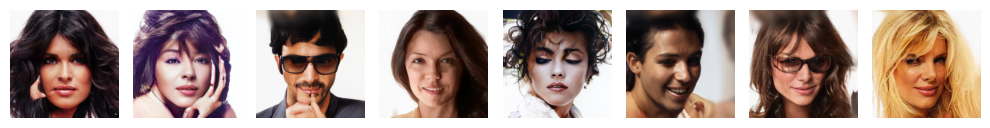

In [18]:
imgs, reconstructed_imgs = test_reconstructions(G, SAE, train_loader, h = 1, w = 8, display = True)